# Project Three Notebook: Tomorrow's Temperature


## By Alessandra Ambrogio

Welcome to my project 3! Given my usually overly complicated ideas for a project, I stuck with something "relatively" simple: determining tomorrow's temperature based on the weather from the past year. Using the average temperature as well as wind speed, humidity, dew point, uv index, visibility, atmospheric pressure, and precipitation, I hope to determine tomorrow's temperature.


Where I found my data:

I was able to find my data using Dark Sky API thanks to Professor Colarusso's suggestion. I was provided a secret key with which to acces the data. I can include the key with this notebook if that is required, desired, or recommended.

What my data says:

Throughout this code sample, I am attempting to use "Today's Temperature," "Yesterday's Temperature," "Today's Humidity," and "Today's Wind Speed" to determine Tomorrow's Temperature. So far, this data demonstrates a correlation between yesterday's temperature, today's temperature, today's wind speed, and today's humidity. 

I want my model to predict tomorrow's temperature with only Today's information.


In [90]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
 
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import random



# Custom functions

def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

def plot_bound(Z_val,data,col1,col2,binary):
    # Z-val equals "Yes" value. E.g., "Y" or "1". 
    # data equals df
    # col1 and col2 defines which colums to use from data
    # Plot binary decision boundary. 
    # For this, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    
    x_min = float(data.iloc[:,[col1]].min())-float(data.iloc[:,[col1]].min())*0.10 
    x_max = float(data.iloc[:,[col1]].max()+float(data.iloc[:,[col1]].min())*0.10)
    y_min = 0.0; 
    y_max = float(training.iloc[:,[col2]].max())+float(training.iloc[:,[col2]].max())*0.10
    h_x = (x_max-x_min)/100  # step size in the mesh
    h_y = (y_max-y_min)/100  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    if binary == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   
        Z = np.where(Z=="Y",1,0)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.pcolormesh(xx, yy, Z)
    plt.show()

In [91]:
# Load and peek at your data. Change the file name as needed. 
raw_data_df = pd.read_csv('Tomorrow.csv', parse_dates=[0]) 
raw_data_df.head()

,Date,Temperature Today in Degrees Fahrenheit,Temperature Yesterday,Temperature Tomorrow,Wind Speed in MPH,Humidity Percentage,Dew Pt in Degress Fahrenheit,UV Index,Visibility by Miles,Pressure in mb,Precipitation in Percentage
0,11/6/17,65.0,56.0,47.0,4.0,86.0,61,1.0,8.0,1010,23
1,11/5/17,56.0,51.0,65.0,3.0,77.0,49,2.0,10.0,1026,0
2,11/4/17,51.0,70.0,56.0,1.0,52.0,34,2.0,10.0,1028,0
3,11/3/17,70.0,65.0,51.0,3.0,72.0,60,2.0,10.0,1015,2
4,11/2/17,65.0,49.0,70.0,2.0,82.0,59,2.0,10.0,1026,1


In [92]:
# You can explore unique entries by stating the column and using .unique() like this:
print(raw_data_df["Temperature Today in Degrees Fahrenheit"].unique())
print(raw_data_df["Temperature Yesterday"].unique())

[ 65.  56.  51.  70.  49.  55.  54.  60.  64.  59.  68.  72.  58.  66.  71.
  69.  62.  61.  75.  73.  74.  81.  76.  79.  78.  67.  77.  80.  63.  82.
  84.  86.  83.  90.  89.  85.  48.  50.  53.  57.  47.  52.  44.  45.  46.
  39.  40.  33.  36.  42.  29.  35.  34.  25.  32.  24.  21.  16.  41.  31.
  26.  19.  23.  27.  38.  30.  43.  37.  17.  20.  22.  28.  12.  nan]
[ 56.  51.  70.  65.  49.  55.  54.  60.  64.  59.  68.  72.  58.  66.  71.
  69.  62.  61.  75.  73.  74.  81.  76.  79.  78.  67.  77.  80.  63.  82.
  84.  86.  83.  90.  89.  85.  48.  50.  53.  57.  47.  52.  44.  45.  46.
  39.  40.  33.  36.  42.  29.  35.  34.  25.  32.  24.  21.  16.  41.  31.
  26.  19.  23.  27.  38.  30.  43.  37.  17.  20.  22.  28.  12.  nan]


In [93]:
# You can explore rows with a specific value like so
raw_data_df[raw_data_df["Temperature Today in Degrees Fahrenheit"]==65].head() # remove .head() to see all entires

,Date,Temperature Today in Degrees Fahrenheit,Temperature Yesterday,Temperature Tomorrow,Wind Speed in MPH,Humidity Percentage,Dew Pt in Degress Fahrenheit,UV Index,Visibility by Miles,Pressure in mb,Precipitation in Percentage
0,11/6/17,65.0,56.0,47.0,4.0,86.0,61,1.0,8.0,1010,23
4,11/2/17,65.0,49.0,70.0,2.0,82.0,59,2.0,10.0,1026,1
19,10/18/17,65.0,51.0,68.0,8.0,43.0,42,3.0,NaN,1024,0
35,10/2/17,65.0,59.0,62.0,9.0,48.0,45,4.0,NaN,1029,0
48,9/19/17,65.0,67.0,67.0,13.0,95.0,63,NaN,4.0,1019,70


In [94]:
# You can count the number of rows like so
print("Size of entire table: %s "%len(raw_data_df))
print("Size of entries matching filter: %s "%len(raw_data_df[raw_data_df["Temperature Today in Degrees Fahrenheit"]==65]))

Size of entire table: 366 
Size of entries matching filter: 9 


In [95]:
# You can invert a match by using the 'not equal' evaluation.
print("Size of entries matching filter: %s "%len(raw_data_df[raw_data_df["Temperature Today in Degrees Fahrenheit"]!=65]))
raw_data_df[raw_data_df["Temperature Today in Degrees Fahrenheit"]!=65].head()

Size of entries matching filter: 357 


,Date,Temperature Today in Degrees Fahrenheit,Temperature Yesterday,Temperature Tomorrow,Wind Speed in MPH,Humidity Percentage,Dew Pt in Degress Fahrenheit,UV Index,Visibility by Miles,Pressure in mb,Precipitation in Percentage
1,11/5/17,56.0,51.0,65.0,3.0,77.0,49,2.0,10.0,1026,0
2,11/4/17,51.0,70.0,56.0,1.0,52.0,34,2.0,10.0,1028,0
3,11/3/17,70.0,65.0,51.0,3.0,72.0,60,2.0,10.0,1015,2
5,11/1/17,49.0,55.0,65.0,0.0,62.0,37,2.0,10.0,1029,1
6,10/31/17,55.0,54.0,49.0,3.0,46.0,35,3.0,10.0,1014,3


In [96]:
# You can make a new table from your filtered rows like so
processed_data_df = raw_data_df[raw_data_df["Temperature Today in Degrees Fahrenheit"]!=65]
processed_data_df = processed_data_df[processed_data_df["Temperature Yesterday"]!=4]
# Note how I filtered first on raw_data_df and then on processed_data_df

# Now let's remove unnecessary data
processed_data_df = processed_data_df[processed_data_df["Visibility by Miles"]!=0]

# So how many entires are there?
print("Size of entire table: %s "%len(processed_data_df))
# Let's peak at the table.
processed_data_df.head()

Size of entire table: 355 


,Date,Temperature Today in Degrees Fahrenheit,Temperature Yesterday,Temperature Tomorrow,Wind Speed in MPH,Humidity Percentage,Dew Pt in Degress Fahrenheit,UV Index,Visibility by Miles,Pressure in mb,Precipitation in Percentage
1,11/5/17,56.0,51.0,65.0,3.0,77.0,49,2.0,10.0,1026,0
2,11/4/17,51.0,70.0,56.0,1.0,52.0,34,2.0,10.0,1028,0
3,11/3/17,70.0,65.0,51.0,3.0,72.0,60,2.0,10.0,1015,2
5,11/1/17,49.0,55.0,65.0,0.0,62.0,37,2.0,10.0,1029,1
6,10/31/17,55.0,54.0,49.0,3.0,46.0,35,3.0,10.0,1014,3


In [97]:
# for the special case of when a value is NaN, you can filter based on the value not being null (i.e., empty)
processed_data_df = processed_data_df[pd.notnull(processed_data_df["Temperature Today in Degrees Fahrenheit"])]
processed_data_df = processed_data_df[pd.notnull(processed_data_df["Temperature Yesterday"])]
print("Size of entire table: %s "%len(processed_data_df)) # in the example data, this gets rid of a few rows
processed_data_df.head()

Size of entire table: 354 


,Date,Temperature Today in Degrees Fahrenheit,Temperature Yesterday,Temperature Tomorrow,Wind Speed in MPH,Humidity Percentage,Dew Pt in Degress Fahrenheit,UV Index,Visibility by Miles,Pressure in mb,Precipitation in Percentage
1,11/5/17,56.0,51.0,65.0,3.0,77.0,49,2.0,10.0,1026,0
2,11/4/17,51.0,70.0,56.0,1.0,52.0,34,2.0,10.0,1028,0
3,11/3/17,70.0,65.0,51.0,3.0,72.0,60,2.0,10.0,1015,2
5,11/1/17,49.0,55.0,65.0,0.0,62.0,37,2.0,10.0,1029,1
6,10/31/17,55.0,54.0,49.0,3.0,46.0,35,3.0,10.0,1014,3


In [98]:
# You can remove unwanted colums like so
# for a single column
processed_data_df = processed_data_df.drop('UV Index', 1)
# for multiple columns
processed_data_df = processed_data_df.drop(['Precipitation in Percentage',
                                            'Visibility by Miles'], 1)
processed_data_df.head()

,Date,Temperature Today in Degrees Fahrenheit,Temperature Yesterday,Temperature Tomorrow,Wind Speed in MPH,Humidity Percentage,Dew Pt in Degress Fahrenheit,Pressure in mb
1,11/5/17,56.0,51.0,65.0,3.0,77.0,49,1026
2,11/4/17,51.0,70.0,56.0,1.0,52.0,34,1028
3,11/3/17,70.0,65.0,51.0,3.0,72.0,60,1015
5,11/1/17,49.0,55.0,65.0,0.0,62.0,37,1029
6,10/31/17,55.0,54.0,49.0,3.0,46.0,35,1014


In [99]:
# Alternativly, if you want to make a new table from a subset of columns, you can do so like this.
processed_data_df = processed_data_df[[
                                        'Temperature Today in Degrees Fahrenheit', 
                                        'Wind Speed in MPH', 
                                        'Humidity Percentage',
                                        'Pressure in mb',
                                        'Dew Pt in Degress Fahrenheit',
                                        'Temperature Yesterday',
                                        'Temperature Tomorrow'
                                     ]].copy()
processed_data_df.head()

,Temperature Today in Degrees Fahrenheit,Wind Speed in MPH,Humidity Percentage,Pressure in mb,Dew Pt in Degress Fahrenheit,Temperature Yesterday,Temperature Tomorrow
1,56.0,3.0,77.0,1026,49,51.0,65.0
2,51.0,1.0,52.0,1028,34,70.0,56.0
3,70.0,3.0,72.0,1015,60,65.0,51.0
5,49.0,0.0,62.0,1029,37,55.0,65.0
6,55.0,3.0,46.0,1014,35,54.0,49.0


In [100]:
# You can rename columns like so.
processed_data_df = processed_data_df.rename(columns={
                                                        'Temperature Today in Degrees Fahrenheit': 'Today', 
                                                        'Wind Speed in MPH': 'Wind',
                                                        'Humidity Percentage': 'Humidity',
                                                        'Pressure in mb': 'Pressure',
                                                        'Dew Pt in Degress Fahrenheit': 'Dew',
                                                        'Temperature Yesterday': 'Yesterday',
                                                        'Temperature Tomorrow': 'Tomorrow'
                                                     })
processed_data_df.head()

,Today,Wind,Humidity,Pressure,Dew,Yesterday,Tomorrow
1,56.0,3.0,77.0,1026,49,51.0,65.0
2,51.0,1.0,52.0,1028,34,70.0,56.0
3,70.0,3.0,72.0,1015,60,65.0,51.0
5,49.0,0.0,62.0,1029,37,55.0,65.0
6,55.0,3.0,46.0,1014,35,54.0,49.0


In [101]:
# I'm now going to make a set of tables to be used in training some models
# The first set will be for linear regressions where the traget is numeric.
# Today
Todays_lin_df = processed_data_df[[
                               'Today', 
                               'Wind', 
                               'Humidity',
                                'Yesterday',
                                'Tomorrow'
                               ]].copy()
Todays_lin_df.head()

,Today,Wind,Humidity,Yesterday,Tomorrow
1,56.0,3.0,77.0,51.0,65.0
2,51.0,1.0,52.0,70.0,56.0
3,70.0,3.0,72.0,65.0,51.0
5,49.0,0.0,62.0,55.0,65.0
6,55.0,3.0,46.0,54.0,49.0


## Training and Validation

Above I created four datasets worth exploring: 
- **`Todays_lin_df`**. The data needed to access *temperature* along a continuous variable.


Let's take them each in turn. 

## Todays_lin_df



In [103]:
data = Todays_lin_df
holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

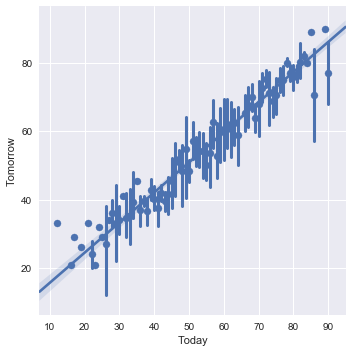

In [110]:
sns.lmplot(x="Today", y="Tomorrow", data=training, x_estimator=np.mean, order=1)

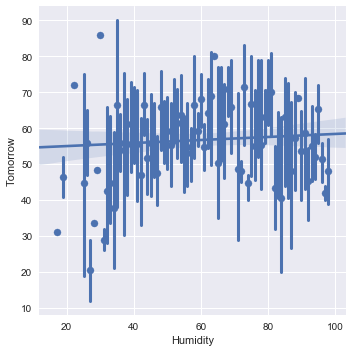

In [111]:
sns.lmplot(x="Humidity", y="Tomorrow", data=training, x_estimator=np.mean, order=1)

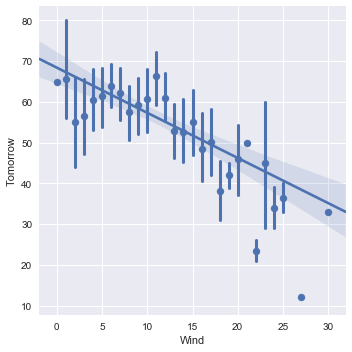

In [112]:
sns.lmplot(x="Wind", y="Tomorrow", data=training, x_estimator=np.mean, order=1)

In [117]:
model = ols("Tomorrow ~ Humidity + Wind + Yesterday + Today", training).fit()
#model = ols("happy ~ age + income + np.power(age, 2) + np.power(income, 2)", training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Tomorrow   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     334.3
Date:                Mon, 27 Nov 2017   Prob (F-statistic):          7.45e-115
Time:                        12:44:55   Log-Likelihood:                -1161.8
No. Observations:                 336   AIC:                             2334.
Df Residuals:                     331   BIC:                             2353.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2862      2.428      3.825      0.000       4.510      14.062
Humidity       0.0463      0.021      2.207      0.028       0.005       0.088
Wind          -0.3542      0.083     -4.257      0.000      -0.518      -0.191
Yesterday      0.0140      0.052      0.268      0.789      -0.089       0.117
Today          0.8407      0.053     15.973      0.000       0.737       0.944
==============================================================================
Omnibus:                       19.236   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.090
Skew:                          -0.522   Prob(JB):                     1.60e-05
Kurtosis:                       3.698   Cond. No.                         592.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
# Rerun with SciKitLearn because it's easy to check accuracy
features_train = training.drop("Tomorrow", axis=1).as_matrix(columns=None)
labels_train = training["Tomorrow"].as_matrix(columns=None)

features_test = holdout.drop("Tomorrow", axis=1).as_matrix(columns=None)
labels_test = holdout["Tomorrow"].as_matrix(columns=None)

lm = linear_model.LinearRegression()
clf = lm.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = metrics.r2_score(labels_test, pred)
print("R squared:",lm.score(features_train,labels_train))
print("Accuracy:",accuracy)

R squared: 0.801592524653
Accuracy: 0.709687030543
